In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import sys
sys.path.append("../../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.util import noise_generator

In [91]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 3

In [130]:
J = lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma)
N = 10000
w_cut = 2000
dw = w_cut/N
N_steps_exact = 500
alphas_exact = np.array([bath_correlation_function.alpha_sum(tau, J, beta, N, dw) for tau in np.linspace(0, duration, N_steps_exact)])

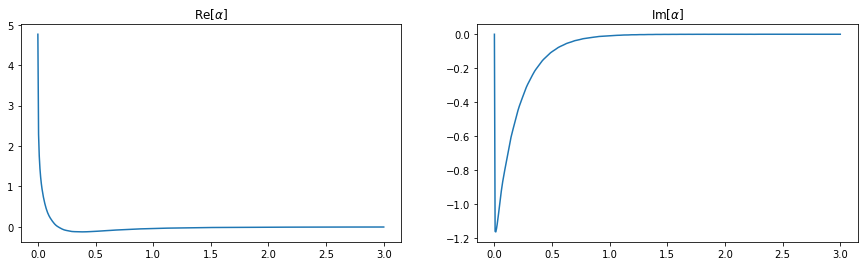

In [131]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_exact))
axarray[0].set_title(r"Re$[\alpha]$")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_exact))
axarray[1].set_title(r"Im$[\alpha]$")
plt.show()

In [116]:
N_terms_list = [5, 10, 15, 20, 50, 100, 1000]

# Default

In [117]:
g, w = debye_spectral_density.get_debye_coefficients(10000, T, gamma, eta)

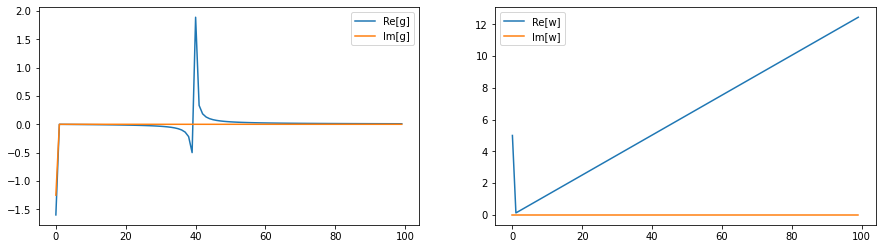

In [118]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
axarray[0].plot(np.real(g)[:100], label="Re[g]")
axarray[0].plot(np.imag(g)[:100], label="Im[g]")
axarray[0].legend()
axarray[1].plot(np.real(w)[:100], label="Re[w]")
axarray[1].plot(np.imag(w)[:100], label="Im[w]")
axarray[1].legend()
plt.show()

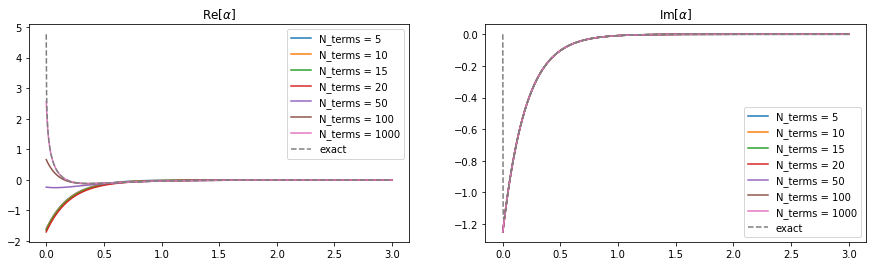

In [119]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
taus = np.linspace(0, duration, N_steps_exact)
for i, N_terms in enumerate(N_terms_list):
    alphas_approx = bath_correlation_function.alpha(taus, g[:N_terms], w[:N_terms])
    axarray[0].plot(taus, np.real(alphas_approx), label="N_terms = "+str(N_terms))
    axarray[1].plot(taus, np.imag(alphas_approx), label="N_terms = "+str(N_terms))
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_exact), "--", label="exact")
axarray[0].set_title(r"Re$[\alpha]$")
axarray[0].legend(loc="upper right")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_exact), "--", label="exact")
axarray[1].set_title(r"Im$[\alpha]$")
axarray[1].legend()
plt.show()

# Ordered

In [120]:
idx = np.flip(np.argsort(np.abs(g)))
g_ordered, w_ordered = g[idx], w[idx]

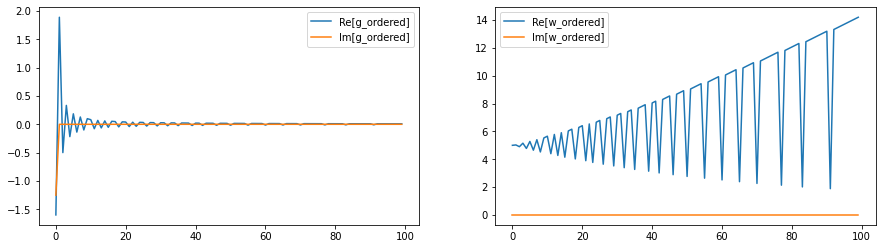

In [121]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
axarray[0].plot(np.real(g_ordered)[:100], label="Re[g_ordered]")
axarray[0].plot(np.imag(g_ordered)[:100], label="Im[g_ordered]")
axarray[0].legend()
axarray[1].plot(np.real(w_ordered)[:100], label="Re[w_ordered]")
axarray[1].plot(np.imag(w_ordered)[:100], label="Im[w_ordered]")
axarray[1].legend()
plt.show()

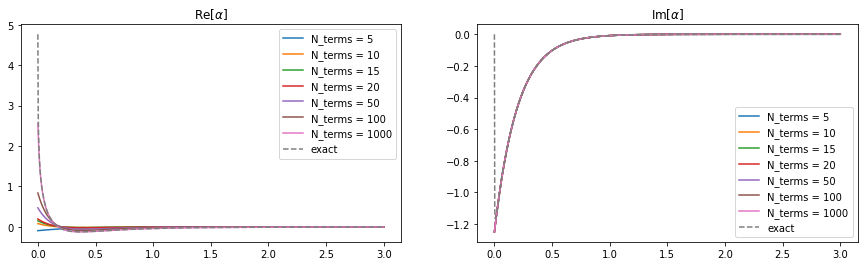

In [122]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
taus = np.linspace(0, duration, N_steps_exact)
for i, N_terms in enumerate(N_terms_list):
    alphas_approx = bath_correlation_function.alpha(taus, g_ordered[:N_terms], w_ordered[:N_terms])
    axarray[0].plot(taus, np.real(alphas_approx), label="N_terms = "+str(N_terms))
    axarray[1].plot(taus, np.imag(alphas_approx), label="N_terms = "+str(N_terms))
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_exact), "--", label="exact")
axarray[0].set_title(r"Re$[\alpha]$")
axarray[0].legend(loc="upper right")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_exact), "--", label="exact")
axarray[1].set_title(r"Im$[\alpha]$")
axarray[1].legend()
plt.show()

# Custom order

Idea: Always choose the coefficient next that minimizes the difference between the approximated and the exact solution!

In [132]:
def difference(alpha_approx, alpha_exact):
    return np.sum(np.abs(alpha_approx - alpha_exact))

In [133]:
# start with g0, w0
N_terms_goal = 100
g_custom = [g[0]]
w_custom = [w[0]]
gs_left = g.copy().tolist()
ws_left = w.copy().tolist()
del gs_left[0]
del ws_left[0]
taus = np.linspace(0, duration, N_steps_exact)
diffs = [difference(bath_correlation_function.alpha(taus, np.array(g_custom), np.array(w_custom)), alphas_exact)]
for n in range(N_terms_goal - 1):
    print("n:", n, "diff:", diffs[-1])
    # find coeff with minimal difference
    min_diff = float("inf")
    min_diff_idx = -1
    for i in range(len(gs_left)):
        gs_temp = np.array(g_custom + [gs_left[i]])
        ws_temp = np.array(w_custom + [ws_left[i]])
        alphas_approx = bath_correlation_function.alpha(taus, gs_temp, ws_temp)
        diff = difference(alphas_approx, alphas_exact)
        if diff < min_diff:
            min_diff = diff
            min_diff_idx = i
    assert min_diff_idx >= 0
    diffs.append(diff)
    g_custom.append(gs_left[min_diff_idx])
    w_custom.append(ws_left[min_diff_idx])
    del gs_left[min_diff_idx]
    del ws_left[min_diff_idx]

n: 0 diff: 69.92915218057382
n: 1 diff: 69.92907404333496
n: 2 diff: 34.79781614511399
n: 3 diff: 34.301921331886
n: 4 diff: 33.80713174591318
n: 5 diff: 33.314908043226396
n: 6 diff: 32.831469362331994
n: 7 diff: 32.35296884609243
n: 8 diff: 31.882649624702406
n: 9 diff: 31.416059403610838
n: 10 diff: 30.95791141980435
n: 11 diff: 30.51649284629549
n: 12 diff: 30.08241172556101
n: 13 diff: 29.653273937291054
n: 14 diff: 29.242551838083184
n: 15 diff: 28.847769301874937
n: 16 diff: 28.465105392326816
n: 17 diff: 28.091130458775133
n: 18 diff: 27.73511794187467
n: 19 diff: 27.404831888078245
n: 20 diff: 27.064382670255977
n: 21 diff: 26.69864013391412
n: 22 diff: 26.356975080352434
n: 23 diff: 26.04032816021923
n: 24 diff: 25.737560657672322
n: 25 diff: 25.451101167685543
n: 26 diff: 25.127616713536234
n: 27 diff: 24.812486016435162
n: 28 diff: 24.529536036170445
n: 29 diff: 24.262485569620825
n: 30 diff: 23.957638816639165
n: 31 diff: 23.69377594336009
n: 32 diff: 23.432072705156134
n:

In [134]:
g_custom = np.array(g_custom)
w_custom = np.array(w_custom)

In [135]:
print("default diff (10000 terms):", difference(bath_correlation_function.alpha(taus, np.array(g), np.array(w)), alphas_exact))
print("default diff (1000 terms):", difference(bath_correlation_function.alpha(taus, np.array(g[:1000]), np.array(w[:1000])), alphas_exact))
print("default diff (100 terms):", difference(bath_correlation_function.alpha(taus, np.array(g[:100]), np.array(w[:100])), alphas_exact))
print("ordered diff (100 terms):", difference(bath_correlation_function.alpha(taus, np.array(g_ordered[:100]), np.array(w_ordered[:100])), alphas_exact))

default diff (10000 terms): 1.7528922894732344
default diff (1000 terms): 3.148179647113325
default diff (100 terms): 13.976334574428096
ordered diff (100 terms): 17.389276958663224


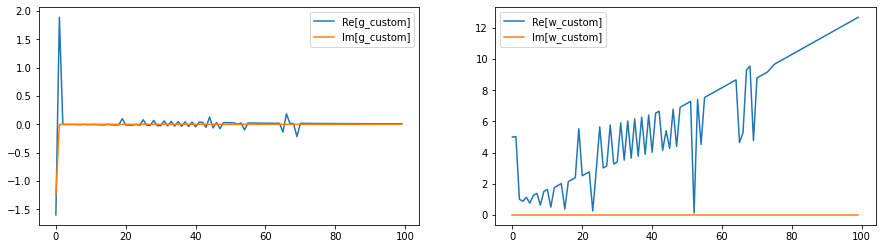

In [136]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
axarray[0].plot(np.real(g_custom)[:100], label="Re[g_custom]")
axarray[0].plot(np.imag(g_custom)[:100], label="Im[g_custom]")
axarray[0].legend()
axarray[1].plot(np.real(w_custom)[:100], label="Re[w_custom]")
axarray[1].plot(np.imag(w_custom)[:100], label="Im[w_custom]")
axarray[1].legend()
plt.show()

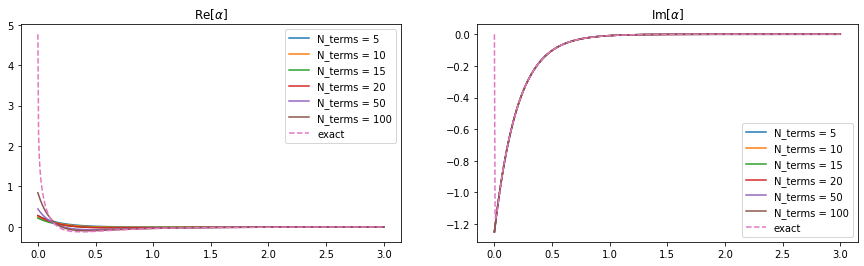

In [137]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
taus = np.linspace(0, duration, N_steps_exact)
for i, N_terms in enumerate(N_terms_list):
    if (N_terms > 100):
        break
    alphas_approx = bath_correlation_function.alpha(taus, g_custom[:N_terms], w_custom[:N_terms])
    axarray[0].plot(taus, np.real(alphas_approx), label="N_terms = "+str(N_terms))
    axarray[1].plot(taus, np.imag(alphas_approx), label="N_terms = "+str(N_terms))
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_exact), "--", label="exact")
axarray[0].set_title(r"Re$[\alpha]$")
axarray[0].legend(loc="upper right")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_exact), "--", label="exact")
axarray[1].set_title(r"Im$[\alpha]$")
axarray[1].legend()
plt.show()

# Comparison of the three

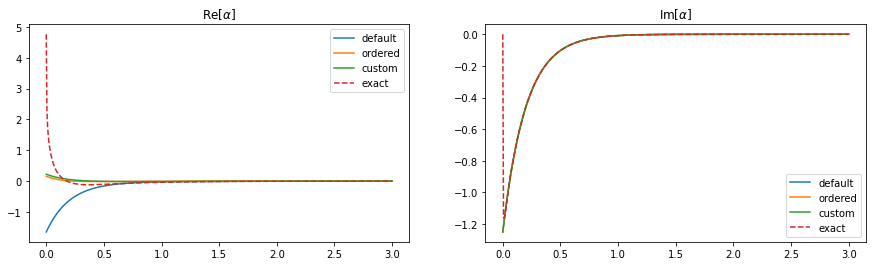

In [139]:
N_terms = 15
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
taus = np.linspace(0, duration, N_steps_exact)

alphas_approx = bath_correlation_function.alpha(taus, g[:N_terms], w[:N_terms])
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_approx), label="default")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_approx), label="default")
alphas_approx = bath_correlation_function.alpha(taus, g_ordered[:N_terms], w_ordered[:N_terms])
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_approx), label="ordered")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_approx), label="ordered")
alphas_approx = bath_correlation_function.alpha(taus, g_custom[:N_terms], w_custom[:N_terms])
axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_approx), label="custom")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_approx), label="custom")

axarray[0].plot(np.linspace(0, duration, N_steps_exact), np.real(alphas_exact), "--", label="exact")
axarray[0].set_title(r"Re$[\alpha]$")
axarray[0].legend(loc="upper right")
axarray[1].plot(np.linspace(0, duration, N_steps_exact), np.imag(alphas_exact), "--", label="exact")
axarray[1].set_title(r"Im$[\alpha]$")
axarray[1].legend()
plt.show()

# Pade decomposition